# Main code

## Importing dataset

In [1]:
#importing dataset from google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
root_dir = "/content/drive/My Drive/dataset/"
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Import Torch
import torch
# Setup device
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


## Creating a custom dataset

In [4]:
# Importing libraries
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from random import shuffle
import numpy as np
%matplotlib inline

In [5]:
transforms = T.Compose([
        T.RandomHorizontalFlip(),
        T.Resize((128,128)), #the images size of test and train_val sets were different (respectively 64x64, 128x128)              
        T.ToTensor()
    ])

In [6]:
train_val_dset = ImageFolder(os.path.join(root_dir, "train"), transform=transforms)
test_dset = ImageFolder(os.path.join(root_dir, "test"), transform=transforms)
#folder function is used

In [7]:
len(train_val_dset)

10245

In [8]:
#splitting train e val
train_len=int(0.8*len(train_val_dset))
val_len=len(train_val_dset)-train_len

In [9]:
train_dset, val_dset = torch.utils.data.random_split(train_val_dset, [train_len, val_len])

In [10]:
dataset, label = train_dset[0]
print(dataset.shape)

torch.Size([3, 128, 128])


In [11]:
len(train_dset)

8196

In [12]:
len(test_dset)

1434

In [13]:
len(val_dset)

2049

In [11]:
train_loader = DataLoader(train_dset, batch_size=32, shuffle=True, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)
val_loader = DataLoader(val_dset, batch_size=32, shuffle=False, drop_last=False, num_workers=2)

## Classification with **2CNN 1FC**
(best combination, val accuracy= 0.703)

In [15]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
       
  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [16]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [17]:
test_x, _ = train_dset[0] 

In [18]:
test_x.size()#get the size of the sample

torch.Size([3, 128, 128])

In [19]:
test_x = test_x.unsqueeze(dim=0) #adding the batch dimension
test_x.size()

torch.Size([1, 3, 128, 128])

In [20]:
output = model(test_x)
output.shape

torch.Size([1, 64, 61, 61])

In [21]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

238144


In [22]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(238144, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 10)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # x has size: [B,64,61,61]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) # now x has size [B, 238144]
    output = self.fc_layers(x) # [B, 238144] --> [B, 1024] --> [B, 10]
    return output

In [23]:
# Create the model
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 10])

In [24]:
torch.cuda.is_available()#recalling GPU

True

In [25]:
dev = torch.device('cuda')
print(dev)

cuda


In [26]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

## Training of the best model

In [27]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [28]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=238144, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Epoch 1: TrL=1.7767, TrA=0.3511, VL=1.6988, VA=0.3937, TeL=1.8817, TeA=0.3509,
Epoch 2: TrL=1.4917, TrA=0.4553, VL=1.4356, VA=0.4755, TeL=1.5561, TeA=0.4351,
Epoch 3: TrL=1.3685, TrA=0.5094, VL=1.3971, VA=0.4962, TeL=1.6563, TeA=0.3950,
Epoch 4: TrL=1.2754, TrA=0.5436, VL=1.3102, VA=0.5255, TeL=1.4324, TeA=0.4901,
Epoch 5: TrL=1.1926, TrA=0.5732, VL=1.1988, VA=0.5764, TeL=1.3347, TeA=0.5322,
Epoch 6: TrL=1.1050, TrA=0.6035, VL=1.3714, VA=0.5139, TeL=1.2422, TeA=0.5516,
Epoch 7: TrL=1.0070, TrA=0.6398, VL=1.0322, VA=0.6490, TeL=1.3681, TeA=0.5378,


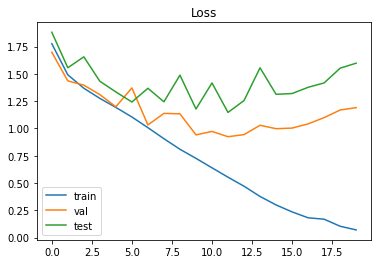

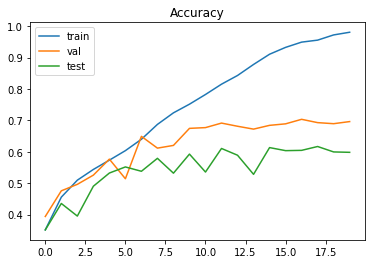

In [29]:
# Train model
train(model, loaders, optimizer, criterion, epochs=20, dev=dev)

At epoch17, the highest validation accuracy is reached.

__________

# Ablation studies

## Classification with 3CNN 1FC

In [30]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
       
  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [31]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [32]:
test_x, _ = train_dset[0]

In [33]:
test_x.size()

torch.Size([3, 128, 128])

In [34]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 128, 128])

In [35]:
output = model(test_x)
output.shape

torch.Size([1, 128, 29, 29])

In [36]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

107648


In [37]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        # Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)

    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(107648, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 10)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # x has size: [B,128,29,29]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) # now x has size [B, 107648]
    output = self.fc_layers(x) # [B, 107648] --> [B, 1024] --> [B, 10]
    return output

In [38]:
# Create the model
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 10])

In [39]:
torch.cuda.is_available()

True

In [40]:
dev = torch.device('cuda')
print(dev)

cuda


In [41]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [42]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [43]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=107648, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Epoch 1: TrL=1.9896, TrA=0.2712, VL=1.7905, VA=0.3510, TeL=1.8007, TeA=0.3170,
Epoch 2: TrL=1.6386, TrA=0.4065, VL=1.5171, VA=0.4558, TeL=1.6610, TeA=0.4145,
Epoch 3: TrL=1.4777, TrA=0.4691, VL=1.4108, VA=0.4947, TeL=1.5532, TeA=0.4366,
Epoch 4: TrL=1.3742, TrA=0.5001, VL=1.3708, VA=0.5019, TeL=1.5088, TeA=0.4504,
Epoch 5: TrL=1.3122, TrA=0.5303, VL=1.2844, VA=0.5409, TeL=1.4744, TeA=0.4760

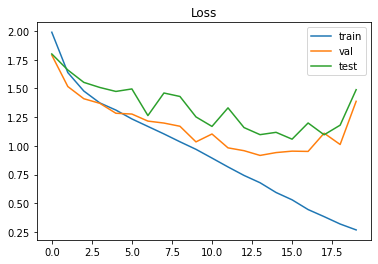

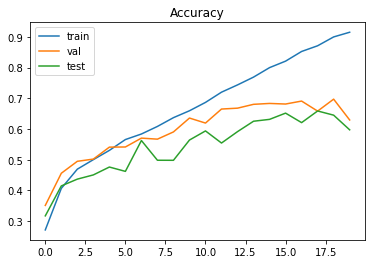

In [44]:
# Train model
train(model, loaders, optimizer, criterion, epochs=20, dev=dev)

In this case, the highest validation accuracy= 0.679 is also reached at epoch 19.

## Classification with 4CNN 1FC 

In [45]:
import torch.nn as nn

class SimpleCNN(nn.Module):

  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
       
  # Forward
  def forward(self, x):
    x = self.conv_layer(x)
    return x

In [46]:
# Create the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [47]:
test_x, _ = train_dset[0]

In [48]:
test_x.size()

torch.Size([3, 128, 128])

In [49]:
test_x = test_x.unsqueeze(dim=0)
test_x.size()

torch.Size([1, 3, 128, 128])

In [50]:
output = model(test_x)
output.shape

torch.Size([1, 256, 13, 13])

In [51]:
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

43264


In [52]:
class CNN(nn.Module):
  #Constructor
  def __init__(self):
    # Call parent contructor
    super().__init__()
    self.conv_layer = nn.Sequential(
        # Layer 1
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=0, stride=1),
        nn.ReLU(),
        # Layer 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        #Layer 4
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    # Create fully-connected layers
    self.fc_layers = nn.Sequential(
        # a first FC layer
        nn.Linear(43264, 1024),
        nn.ReLU(),
        # the final Classification Layer
        nn.Linear(1024, 10)
    )

  # Forward
  def forward(self, x):
    x = self.conv_layer(x) # x has size: [B,256,13,13]; before passing to fc layer, we have to flatten x
    x = x.view(x.size(0), -1) # now x has size [B, 43264
    output = self.fc_layers(x) # [B, 43264] --> [B, 1024] --> [B, 10]
    return output

In [53]:
# Create the model
model = CNN()
output = model(test_x)
output.shape

torch.Size([1, 10])

In [54]:
torch.cuda.is_available()

True

In [55]:
dev = torch.device('cuda')
print(dev)

cuda


In [56]:
# Define an optimizier
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = 0.01)
# Define a loss 
criterion = nn.CrossEntropyLoss()

In [57]:
def train(net, loaders, optimizer, criterion, epochs=100, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []}
        history_accuracy = {"train": [], "val": [], "test": []}
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                # Process each batch
                for (input, labels) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    pred = net(input)
                    loss = criterion(pred, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

In [58]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=43264, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Epoch 1: TrL=2.1473, TrA=0.2133, VL=2.0186, VA=0.2543, TeL=2.0717, TeA=0.2651,
Epoch 2: TrL=1.7877, TrA=0.3506, VL=1.6704, VA=0.4024, TeL=1.7120, TeA=0.3649,
Epoch 3: TrL=1.6238, TrA=0.4135, VL=1.5324, VA=0.4601, TeL=1.5524, TeA=0.4

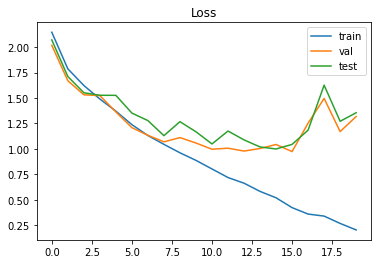

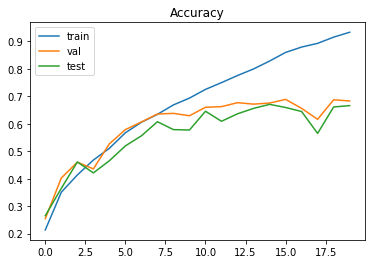

In [59]:
# Train model
train(model, loaders, optimizer, criterion, epochs=20, dev=dev)

Here, at epoch 16 we obtain the highest level of accuracy, 0.6889.

# Additional comments

Generally speaking, the highest validation accuracy reached
is 0.703. Lots of other parameter's combinations have been also proven (increasing the batch size or decreasing the in and out features) but the model, above provided, seems to be the best one. Probably, better results can be obtained with fine tuning or off the shelf procedure.